**Walmart – Demand Forecasting & Supply Chain**

/tmp/ipython-input-915011708.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c] = df.groupby("Store")[c].transform(lambda x: x.fillna(method="ffill").fillna(method="bfill")).fillna(df[c].median())
/tmp/ipython-input-915011708.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["Store", "Dept"], group_keys=False).apply(create_group_lags)


Training Gradient Boosting Regressor...
Model RMSE: 2630.39
Predictions saved as walmart_forecasts.csv


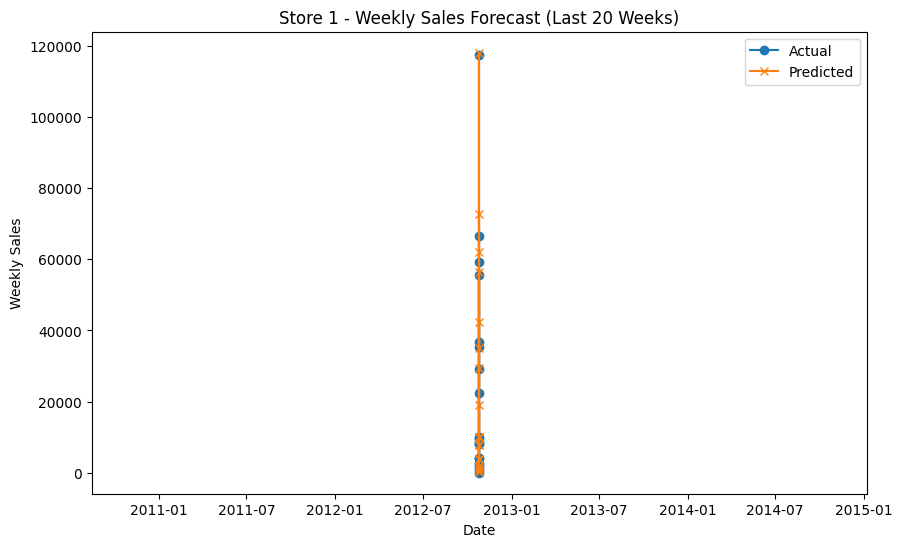

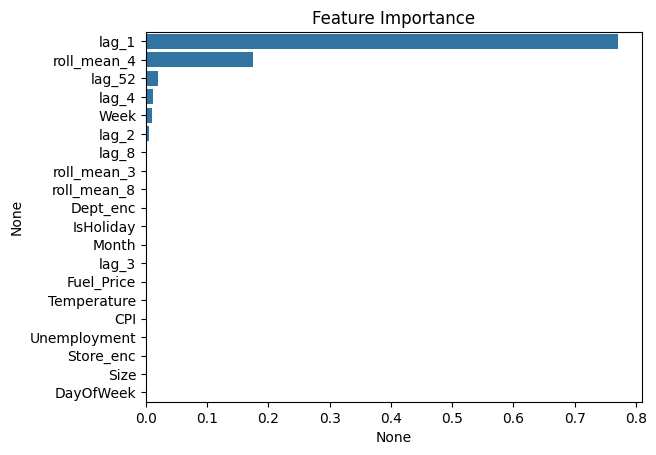

In [5]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD DATA
train = pd.read_csv("/content/train.csv", parse_dates=["Date"])
features = pd.read_csv("/content/features.csv", parse_dates=["Date"])
stores = pd.read_csv("/content/stores.csv")

# Merge all datasets
df = pd.merge(train, features, on=["Store", "Date"], how="left")
df = pd.merge(df, stores, on="Store", how="left")

# Handle duplicate IsHoliday columns
if "IsHoliday_x" in df.columns and "IsHoliday_y" in df.columns:
    df = df.rename(columns={"IsHoliday_x": "IsHoliday"}).drop(columns=["IsHoliday_y"])

#  CLEANING
# Fill missing values for Markdown columns
markdown_cols = [c for c in df.columns if "MarkDown" in c]
for c in markdown_cols:
    df[c] = df[c].fillna(0)

# Fill missing numeric columns
num_cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df.groupby("Store")[c].transform(lambda x: x.fillna(method="ffill").fillna(method="bfill")).fillna(df[c].median())

# FEATURE ENGINEERING
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
df["DayOfWeek"] = df["Date"].dt.dayofweek

# Sort by date
df = df.sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)

# Create lag & rolling features
lag_features = [1, 2, 3, 4, 8, 52]
rolling_windows = [3, 4, 8]

def create_group_lags(g):
    original_index = g.index
    g = g.sort_values("Date").reset_index(drop=True).copy()
    for lag in lag_features:
        g[f"lag_{lag}"] = g["Weekly_Sales"].shift(lag)
    for rw in rolling_windows:
        g[f"roll_mean_{rw}"] = g["Weekly_Sales"].shift(1).rolling(window=rw, min_periods=1).mean()
    g.index = original_index # Restore original index
    return g

df = df.groupby(["Store", "Dept"], group_keys=False).apply(create_group_lags)
df = df.dropna(subset=["lag_1"]).reset_index(drop=True)

# Encode categorical
le_store = LabelEncoder()
le_dept = LabelEncoder()
df["Store_enc"] = le_store.fit_transform(df["Store"])
df["Dept_enc"] = le_dept.fit_transform(df["Dept"])

# MODEL FEATURES
feature_cols = [
    "Store_enc", "Dept_enc", "lag_1", "lag_2", "lag_3", "lag_4", "lag_8", "lag_52",
    "roll_mean_3", "roll_mean_4", "roll_mean_8", "Temperature", "Fuel_Price", "CPI",
    "Unemployment", "IsHoliday", "Week", "Month", "DayOfWeek", "Size"]

# Fill missing values
for c in feature_cols:
    if c in df.columns:
        if df[c].dtype.kind in "biufc":
            df[c] = df[c].fillna(df[c].median())
        else:
            df[c] = df[c].fillna(0)

# TRAIN / TEST SPLIT
max_date = df["Date"].max()
cutoff = max_date - pd.Timedelta(weeks=16)
train_df = df[df["Date"] <= cutoff]
test_df = df[df["Date"] > cutoff]

X_train = train_df[feature_cols]
y_train = train_df["Weekly_Sales"]
X_test = test_df[feature_cols]
y_test = test_df["Weekly_Sales"]

# MODEL TRAINING
print("Training Gradient Boosting Regressor...")
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# PREDICTION
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Model RMSE: {rmse:.2f}")

# OUTPUT
pred_df = test_df[["Store", "Dept", "Date", "Weekly_Sales"]].copy()
pred_df["Predicted_Weekly_Sales"] = y_pred
pred_df.to_csv("walmart_forecasts.csv", index=False)
print("Predictions saved as walmart_forecasts.csv")

# VISUALIZATION
plt.figure(figsize=(10, 6))
sample_store = pred_df[pred_df["Store"] == 1].sort_values("Date").tail(20)
plt.plot(sample_store["Date"], sample_store["Weekly_Sales"], label="Actual", marker="o")
plt.plot(sample_store["Date"], sample_store["Predicted_Weekly_Sales"], label="Predicted", marker="x")
plt.title("Store 1 - Weekly Sales Forecast (Last 20 Weeks)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

# Feature importance
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance")
plt.show()